In [27]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [36]:
actions = [
    '안녕하세요',
    '만나다',
    '반갑다'
]

data = np.concatenate([
    np.load('dataset/0_안녕하세요_.npy'),
    np.load('dataset/1_만나다_.npy'),
    np.load('dataset/2_반갑다_.npy'),
], axis=0)

data.shape

(1318, 30, 199)

In [37]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape) # 라벨의 원핫 인코딩 필요

# print('\n수어 인덱스')
# idxes = {}
# for i in labels:
#     if i not in idxes:
#         idxes[i] = True
#         print(i)

(1318, 30, 198)
(1318,)


In [38]:
# 원핫 인코딩
# ex
# 0 [1, 0, 0]
# 1 [0, 1, 0]
# 2 [0, 0, 1]

from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1318, 3)

In [39]:
# 데이터를 학습(train)과 검증(validation) 세트로 나눔 -> 모델의 성능을 평가 && 과적합 방지
# 과적합: 데이터 크기 작을 때 || 단일 샘플 데이터 세트 장기간 훈련
# x: 입력, y: 출력
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1186, 30, 198) (1186, 3)
(132, 30, 198) (132, 3)


In [44]:
# 모델 구조 정의, 컴파일
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), # (512,30,99)[1:3] => (30,99): (시퀀스 길이, 특징 수)
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                67328     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 69,507
Trainable params: 69,507
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 모델 훈련 (epochs=200: 학습량)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[
        ModelCheckpoint('model_ko.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 11.7167 - acc: 0.6050
Epoch 00001: val_acc improved from -inf to 0.40152, saving model to model_ko.h5
38/38 [==============================] - 5s 143ms/step - loss: 12.0886 - acc: 0.5944 - val_loss: 18.6620 - val_acc: 0.4015
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 4.0904 - acc: 0.8078
Epoch 00002: val_acc improved from 0.40152 to 0.99242, saving model to model_ko.h5
38/38 [==============================] - 1s 28ms/step - loss: 4.0904 - acc: 0.8078 - val_loss: 0.0344 - val_acc: 0.9924
Epoch 3/50
36/38 [===========================>..] - ETA: 0s - loss: 0.0384 - acc: 0.9965
Epoch 00003: val_acc did not improve from 0.99242
38/38 [==============================] - 1s 24ms/step - loss: 0.0373 - acc: 0.9966 - val_loss: 0.0616 - val_acc: 0.9773
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.0240 - acc: 0.9958
Epoch 00004: val_acc did not improve from 0.99242
38/38 [==========

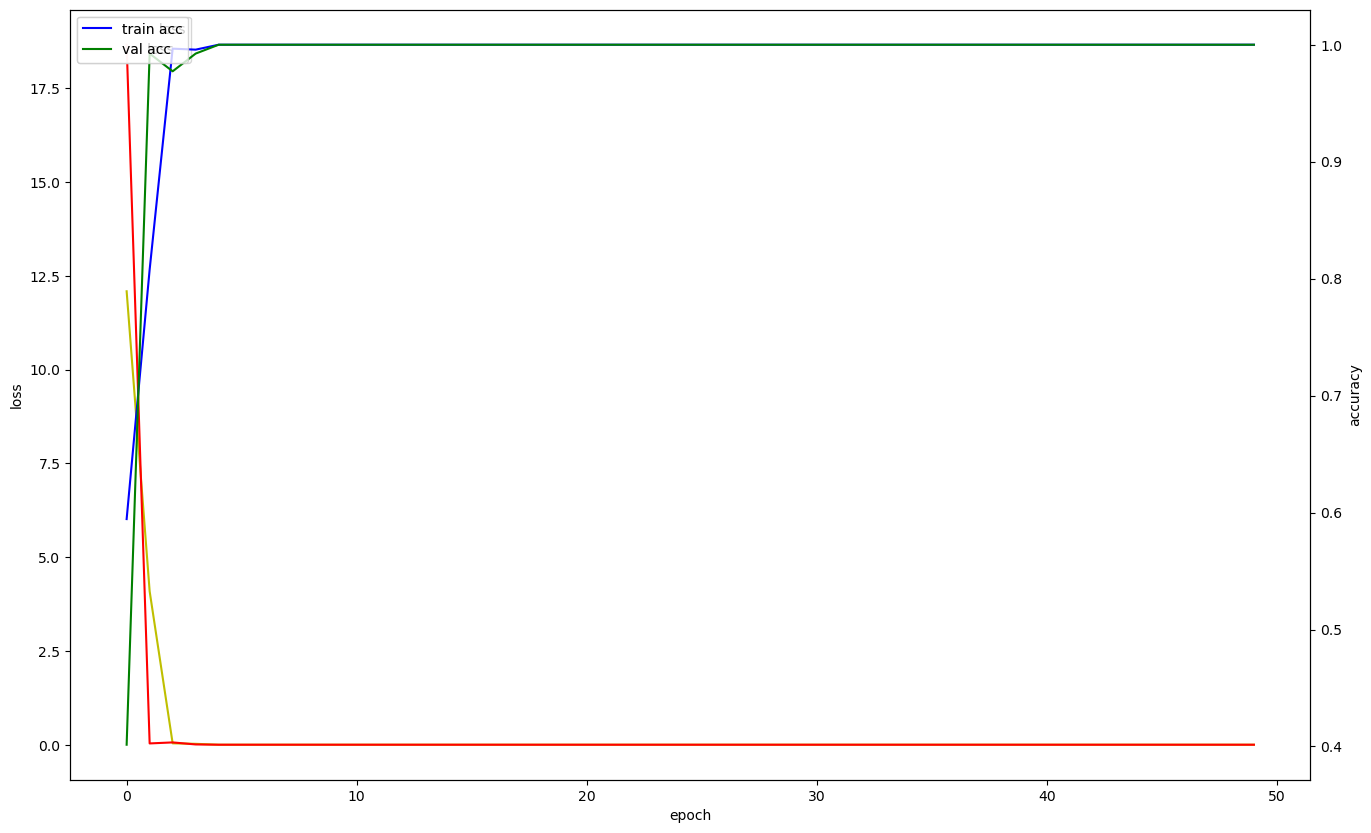

In [46]:
# 훈련 과정에서 발생한 손실(loss) 및 정확도(accuracy)를 시각화

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [47]:
# 모델의 예측 결과와 실제 레이블 간의 다중 레이블 혼동 행렬(multilabel confusion matrix)을 계산하는 작업을 수행

from sklearn.metrics import multilabel_confusion_matrix


y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

# 실행 결과 예시
# WARNING:tensorflow:Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
# array([[[94,  1],
#         [ 0, 34]],

#        [[81,  0],
#         [ 0, 47]],

#        [[81,  0],
#         [ 0, 47]]])

# 예시로 해석
# True Positive (TP): 모델이 양성(Positive)으로 예측한 것 중에서 실제로 양성인 경우의 수. (94)
# True Negative (TN): 모델이 음성(Negative)으로 예측한 것 중에서 실제로 음성인 경우의 수. (34))
# False Positive (FP): 모델이 양성(Positive)으로 잘못 예측한 것 중에서 실제로는 음성인 경우의 수. (0: 모델이 양성으로 잘못 예측한 경우가 없음)
# False Negative (FN): 모델이 음성(Negative)으로 잘못 예측한 것 중에서 실제로는 양성인 경우의 수. (1)

array([[[89,  0],
        [ 0, 43]],

       [[93,  0],
        [ 0, 39]],

       [[82,  0],
        [ 0, 50]]], dtype=int64)